# 0. Setting 

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from neuralprophet import NeuralProphet, df_utils, set_random_seed, set_log_level

set_log_level("ERROR")

from TimesNet_code import metrics

# 1. Peyton Manning

- 1998~2015년 IND, DEN 소속으로 활약한 선수
- Super Bowl 2006, 2009, 2013, 2015 출전
- 데이터셋: 2007.12.10 ~ 2016.01.20 위키피디아 조회수

In [ ]:
# print(len(df1[:1743])/len(df1)*100, len(df1[1743:(1743+581)])/len(df1)*100, len(df1[(1743+581):(1743+581+581)])/len(df1)*100) # 60.0 20.0 20.0
# print(len(df1[:1743]), len(df1[1743:(1743+581)]), len(df1[(1743+581):(1743+581+581)])) # 1743 581 581
# display(df1[:1743]) # train: 2007-12-10 ~ 2012-11-09
# display(df1[1743:(1743+581)]) # validation: 2012-11-10 ~ 2014-06-15
# display(df1[(1743+581):(1743+581+581)]) # test: 2014-06-16 ~ 2016-01-20

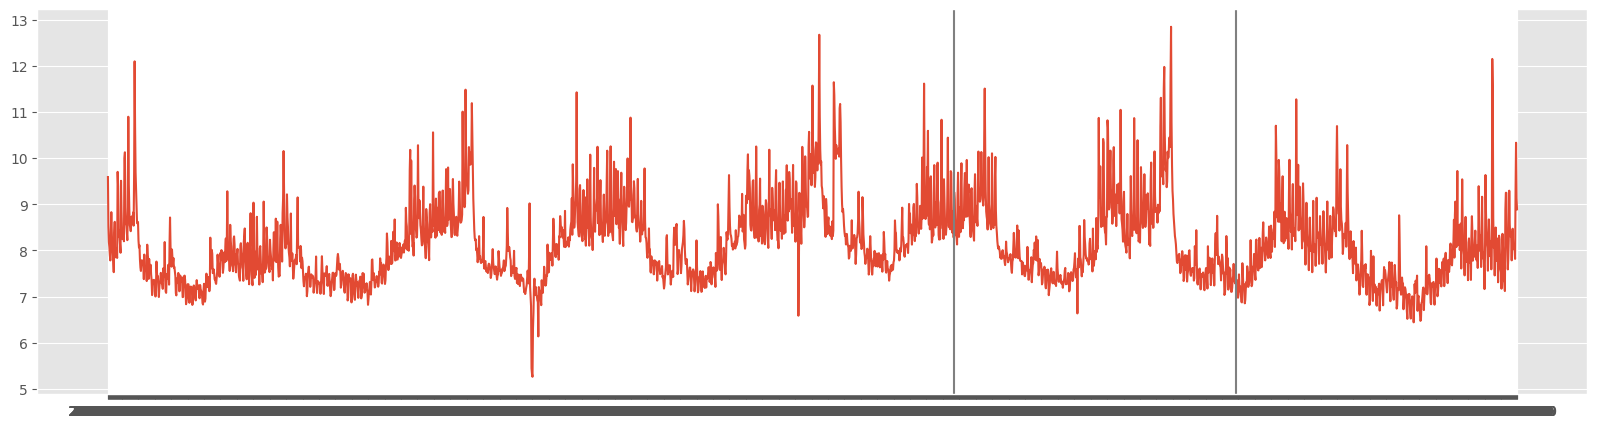

In [2]:
df1 = pd.read_csv("https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets_raw/wp_log_peyton_manning.csv")

plt.figure(figsize=(20, 5))
plt.plot(df1.ds, df1.y)
plt.axvline('2012-11-10', color = 'gray') # validation
plt.axvline('2014-06-16', color = 'gray') # test
plt.show()


In [2]:
# 미식축구 관련 이벤트 기간

playoffs = pd.DataFrame({
  'event': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
})

superbowls = pd.DataFrame({
  'event': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
})

holidays = pd.concat((playoffs, superbowls))

def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 2)

def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
    
def nfl_season_on(ds):
    date = pd.to_datetime(ds)
    if (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0  

def nfl_season_off(ds):
    date = pd.to_datetime(ds)
    if (date.month > 8 or date.month < 2):
        return 0
    else:
        return 1       


In [3]:
df1 = pd.read_csv("https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets_raw/wp_log_peyton_manning.csv")

df_train = df1[df1.ds < '2012-11-10']
df_valid = df1[('2012-11-10' <= df1.ds) & (df1.ds < '2014-06-16')].reset_index(drop = True)
df_test = df1['2014-06-16' <= df1.ds].reset_index(drop = True)

METRICS = ["MAE", "RMSE"]
METRICS_VAL = ["MAE_val", "RMSE_val"]


In [6]:
len(df_train), len(df_valid), len(df_test)

(1743, 581, 581)

In [12]:
## cross validation use then check code
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {
    'weekly_seasonality': False,
    'n_lags': 3,
    'ar_layers': [1, 32]    
}

m = NeuralProphet(**config)

m.add_events('playoff')
m.add_events('superbowl')
hum_2_hol = m.create_df_with_events(hum_2, holidays)

hum_2_hol['nfl_season_on'] = hum_2_hol['ds'].apply(nfl_season_on)
hum_2_hol['nfl_sunday'] = hum_2_hol['ds'].apply(nfl_sunday)
hum_2_hol = df_utils.add_quarter_condition(hum_2_hol)

df_train = hum_2_hol[hum_2_hol.ds < '2015-01-01']
df_test = hum_2_hol[hum_2_hol.ds >= '2014-12-29'].reset_index(drop = True)

folds = m.crossvalidation_split_df(df_train, freq = 'D', k = 5, fold_pct = 0.06, fold_overlap_pct=0)

for train_df, valid_df in folds:

    train_df['nfl_season_on'] = train_df['ds'].apply(nfl_season_on)
    train_df['nfl_sunday'] = train_df['ds'].apply(nfl_sunday)
    train_df = df_utils.add_quarter_condition(train_df)

    valid_df['nfl_season_on'] = valid_df['ds'].apply(nfl_season_on)
    valid_df['nfl_sunday'] = valid_df['ds'].apply(nfl_sunday)
    valid_df = df_utils.add_quarter_condition(valid_df)

    m = NeuralProphet(**config)
    m.add_country_holidays(country_name='US')
    m.add_events(['playoff', 'superbowl', 'nfl_season_on', 'nfl_sunday'], lower_window = 0, upper_window = 1)
    m.add_seasonality(name="weekly_summer", period=7, fourier_order=3, condition_name="summer")
    m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
    m.add_seasonality(name="weekly_winter", period=7, fourier_order=3, condition_name="winter")
    m.add_seasonality(name="weekly_spring", period=7, fourier_order=3, condition_name="spring")
    train = m.fit(df=train_df, freq="D")
    valid = m.test(df=valid_df)
    metrics_train = metrics_train.append(train[METRICS].iloc[-1])
    metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train.describe().loc[["mean", "std"]])
display(metrics_valid.describe().loc[["mean", "std"]])

p_train = m.predict(df_train)
p_test = m.predict(df_test)

metrics.metric_check(p_train.yhat1.values[3:], p_train.y.values[3:], p_train.y.values[3:])
metrics.metric_check(p_test.yhat1.values[3:], p_test.y.values[3:], p_train.y.values[3:])


NameError: name 'hum_2' is not defined

## 자동

In [14]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {}

m = NeuralProphet(**config)
train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_test)

metrics.metric_check(p_test.yhat1.values, p_test.y.values)


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18660\3711599659.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18660\3711599659.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.020576966926455498
         MAE_val            0.8000026941299438
        RMSE_val            0.9125685095787048
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
163,0.34096,0.472095


,MAE_val,RMSE_val
0,0.800003,0.912569


Predicting: 55it [00:00, ?it/s]

MAE:  1.2952556745295996 ,  MSE:  1.9260591890492054 ,  RMSE:  1.3878253452971687 ,  MAPE:  0.1678658469130537 ,  MSPE:  0.0331039644995422


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18660\2513080005.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_df = m.predict(df_train.append(df_valid).append(df_test))

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18660\2513080005.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_df = m.predict(df_train.append(df_valid).append(df_test))



Predicting: 55it [00:00, ?it/s]

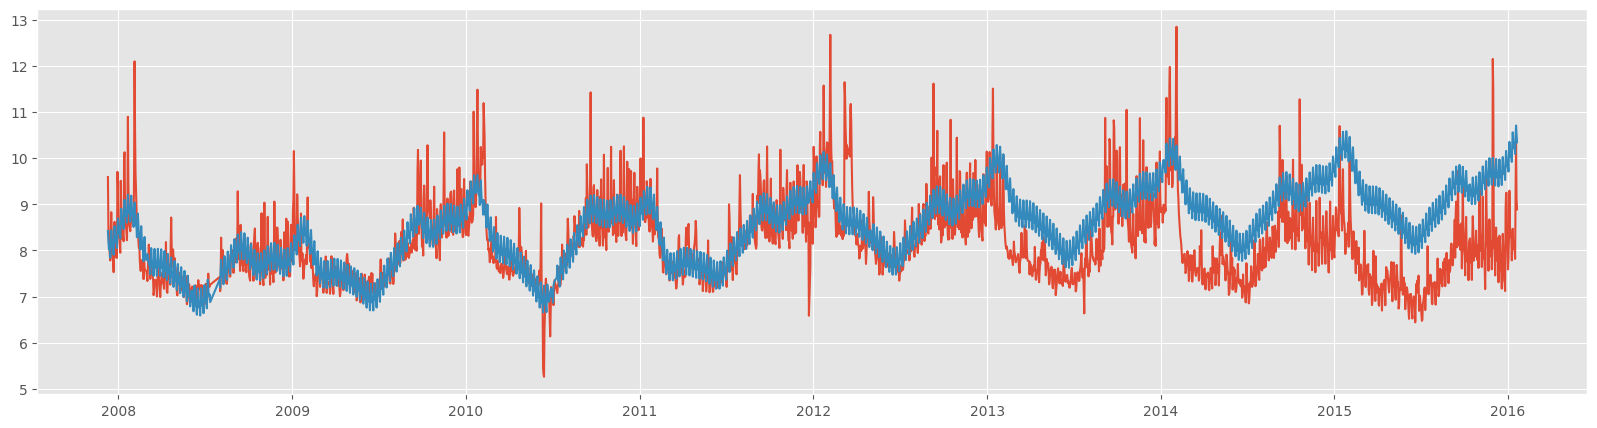

In [15]:
p_df = m.predict(df_train.append(df_valid).append(df_test))

plt.figure(figsize=(20, 5))
plt.plot(p_df.ds, p_df.y)
plt.plot(p_df.ds, p_df.yhat1)


## US 추가

In [7]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {}
m = NeuralProphet(**config)
m.add_country_holidays(country_name='US')

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_test)

metrics.metric_check(p_test.yhat1.values, p_test.y.values)


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10152\2648658860.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10152\2648658860.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.02051757648587227
         MAE_val            0.8024988770484924
        RMSE_val            0.9112504720687866
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
163,0.332759,0.462062


,MAE_val,RMSE_val
0,0.802499,0.91125


Predicting: 55it [00:00, ?it/s]

MAE:  1.2988767578531981 ,  MSE:  1.9319407435186413 ,  RMSE:  1.3899427123153822 ,  MAPE:  0.1682662314000982 ,  MSPE:  0.03318084571830628


## Playoff/Superbowl 추가

In [6]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {}
m = NeuralProphet(**config)
m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

m.add_country_holidays(country_name='US')

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_test)

metrics.metric_check(p_test.yhat1.values, p_test.y.values)



Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10276\2824235773.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10276\2824235773.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.0196840837597847
         MAE_val            0.7851083278656006
        RMSE_val            0.8925496935844421
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
163,0.324501,0.447252


,MAE_val,RMSE_val
0,0.785108,0.89255


Predicting: 55it [00:00, ?it/s]

MAE:  1.2908544762040988 ,  MSE:  1.907667089165022 ,  RMSE:  1.3811832207078907 ,  MAPE:  0.16705012845917763 ,  MSPE:  0.03265745357966848


## nfl season sunday 추가


### event/hol

In [4]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {}
m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

m.add_events('nfl_sunday', lower_window = 0, upper_window = 1)
m.add_country_holidays(country_name='US')
train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_test)

metrics.metric_check(p_test.yhat1.values, p_test.y.values)


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28780\1670777057.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28780\1670777057.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.019216954708099365
         MAE_val             0.77763831615448
        RMSE_val            0.8818953037261963
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
163,0.298931,0.422322


,MAE_val,RMSE_val
0,0.777638,0.881895


Predicting: 55it [00:00, ?it/s]

MAE:  1.286677898423421 ,  MSE:  1.8869323824303983 ,  RMSE:  1.373656573685868 ,  MAPE:  0.1663128363021715 ,  MSPE:  0.03216114571980601


### future reg

In [5]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {}
m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

m.add_country_holidays(country_name='US')
m.add_future_regressor('nfl_sunday')

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_test)

metrics.metric_check(p_test.yhat1.values, p_test.y.values)


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28780\1987867216.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28780\1987867216.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.01973319984972477
         MAE_val            0.7881581783294678
        RMSE_val            0.8936625719070435
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
163,0.312668,0.436595


,MAE_val,RMSE_val
0,0.788158,0.893663


Predicting: 55it [00:00, ?it/s]

MAE:  1.2965354238279507 ,  MSE:  1.9213074308800537 ,  RMSE:  1.3861123442492147 ,  MAPE:  0.1677047571018822 ,  MSPE:  0.032813126659191214


## nfl season on/off 추가

### event/hol

In [7]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {}
m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_season'] = df_hol['ds'].apply(nfl_season_on)
df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

m.add_country_holidays(country_name='US')
m.add_events(['nfl_season', 'nfl_sunday'], lower_window = 0, upper_window = 1)

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_test)

metrics.metric_check(p_test.yhat1.values, p_test.y.values)


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28780\3611682113.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28780\3611682113.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.019204596057534218
         MAE_val            0.7771412134170532
        RMSE_val             0.881611704826355
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
163,0.298705,0.423558


,MAE_val,RMSE_val
0,0.777141,0.881612


Predicting: 55it [00:00, ?it/s]

MAE:  1.2894948351771482 ,  MSE:  1.8950408427638035 ,  RMSE:  1.3766048244735318 ,  MAPE:  0.16665641527065547 ,  MSPE:  0.032282920671719284


### weekly seasonality

In [8]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {}
m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['on_season'] = df_hol['ds'].apply(is_nfl_season)
df_hol['off_season'] = ~df_hol['ds'].apply(is_nfl_season)
df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

m.add_country_holidays(country_name='US')
m.add_events('nfl_sunday', lower_window = 0, upper_window = 1)
m.add_seasonality(name = 'weekly_on_season', period = 7, fourier_order = 3, condition_name = 'on_season')
m.add_seasonality(name = 'weekly_off_season', period = 7, fourier_order = 3, condition_name = 'off_season')

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_test)

metrics.metric_check(p_test.yhat1.values, p_test.y.values)


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28780\681592735.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28780\681592735.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.018814286217093468
         MAE_val            0.7703185677528381
        RMSE_val            0.8726069331169128
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
163,0.29106,0.412112


,MAE_val,RMSE_val
0,0.770319,0.872607


Predicting: 55it [00:00, ?it/s]

MAE:  1.296625140692389 ,  MSE:  1.9062372688814746 ,  RMSE:  1.3806655166554551 ,  MAPE:  0.1675152662571292 ,  MSPE:  0.0324408163989616


## 봄/여름/가을/겨울 weekly seasonality 추가

In [9]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {'weekly_seasonality': False}
m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_season_on'] = df_hol['ds'].apply(nfl_season_on)
df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)

df_hol = df_utils.add_quarter_condition(df_hol)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

m.add_country_holidays(country_name='US')
m.add_events(['nfl_season_on', 'nfl_sunday'], lower_window = 0, upper_window = 1)
m.add_seasonality(name="weekly_summer", period=7, fourier_order=3, condition_name="summer")
m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
m.add_seasonality(name="weekly_winter", period=7, fourier_order=3, condition_name="winter")
m.add_seasonality(name="weekly_spring", period=7, fourier_order=3, condition_name="spring")

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_test)

metrics.metric_check(p_test.yhat1.values, p_test.y.values)


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28780\742271303.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28780\742271303.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.018664736300706863
         MAE_val            0.7650378942489624
        RMSE_val            0.8691319227218628
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
163,0.288571,0.409256


,MAE_val,RMSE_val
0,0.765038,0.869132


Predicting: 55it [00:00, ?it/s]

MAE:  1.2942318390775178 ,  MSE:  1.90055569242794 ,  RMSE:  1.3786064313022552 ,  MAPE:  0.16720992865103323 ,  MSPE:  0.03236798471513168


## monthly seasonality 추가

In [9]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {'weekly_seasonality': False}
m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_season_on'] = df_hol['ds'].apply(nfl_season_on)
df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)

df_hol = df_utils.add_quarter_condition(df_hol)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

m.add_country_holidays(country_name='US')
m.add_events(['nfl_season_on', 'nfl_sunday'], lower_window = 0, upper_window = 1)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
m.add_seasonality(name="weekly_summer", period=7, fourier_order=3, condition_name="summer")
m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
m.add_seasonality(name="weekly_winter", period=7, fourier_order=3, condition_name="winter")
m.add_seasonality(name="weekly_spring", period=7, fourier_order=3, condition_name="spring")

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_test)

metrics.metric_check(p_test.yhat1.values, p_test.y.values)


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18660\631942081.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18660\631942081.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.019002145156264305
         MAE_val            0.7702980637550354
        RMSE_val            0.8769525289535522
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
163,0.290001,0.407683


,MAE_val,RMSE_val
0,0.770298,0.876953


Predicting: 55it [00:00, ?it/s]

MAE:  1.2871688199282119 ,  MSE:  1.8943013265917785 ,  RMSE:  1.3763361967890617 ,  MAPE:  0.1663571260375577 ,  MSPE:  0.03227388396509727


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18660\2513080005.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_df = m.predict(df_train.append(df_valid).append(df_test))

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18660\2513080005.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_df = m.predict(df_train.append(df_valid).append(df_test))



Predicting: 55it [00:00, ?it/s]

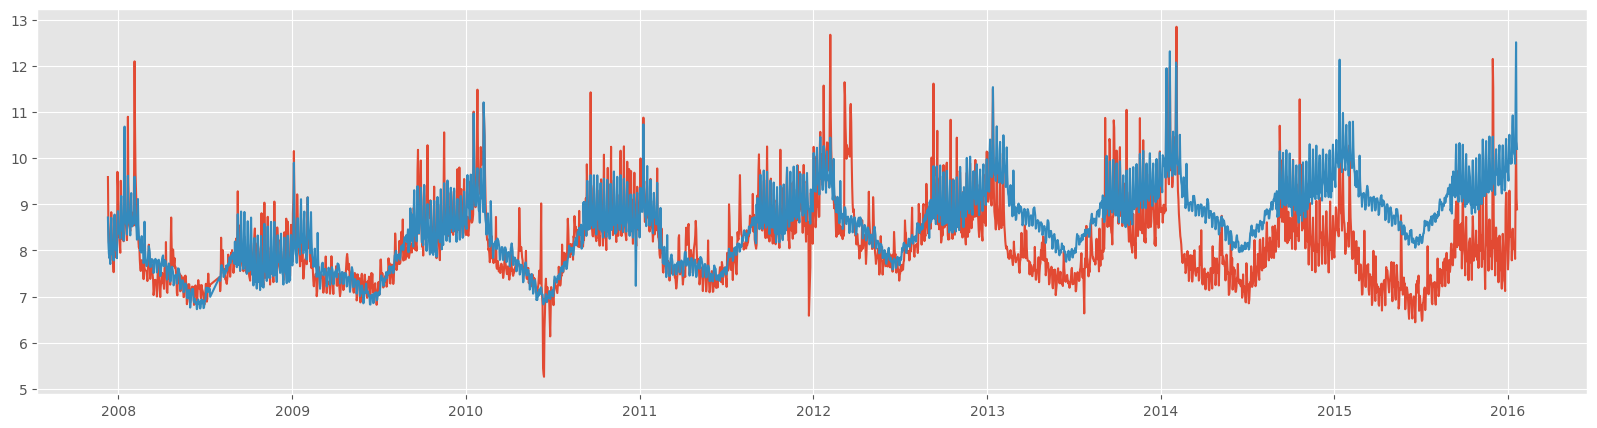

In [10]:
p_df = m.predict(df_train.append(df_valid).append(df_test))

plt.figure(figsize=(20, 5))
plt.plot(p_df.ds, p_df.y)
plt.plot(p_df.ds, p_df.yhat1)


## AR lag 추가

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\814457819.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_train = m.predict(df_train.append(df_valid))



Predicting: 55it [00:00, ?it/s]

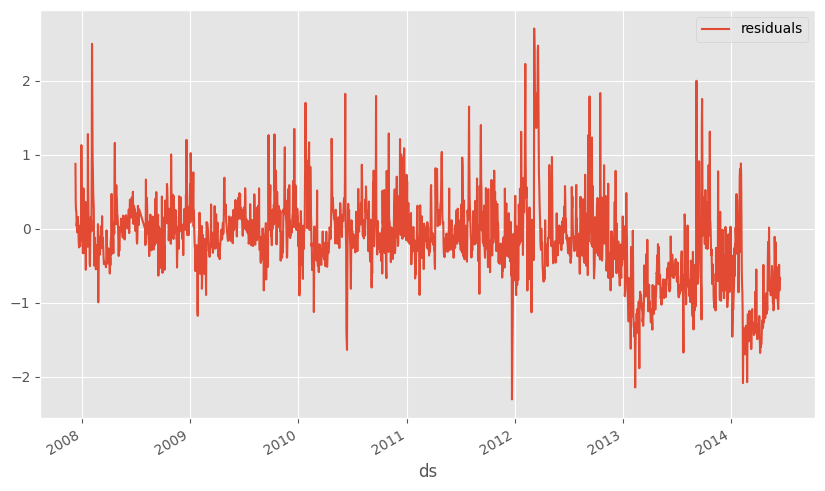

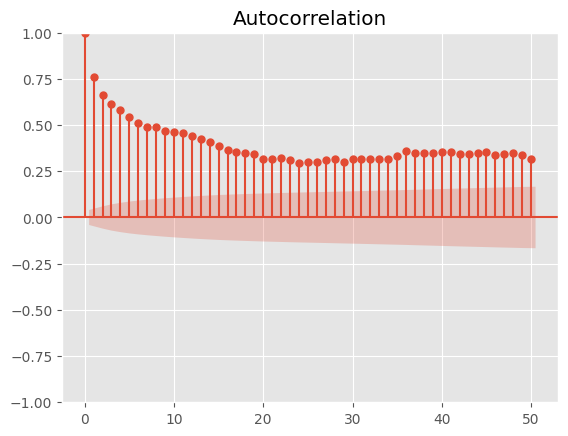

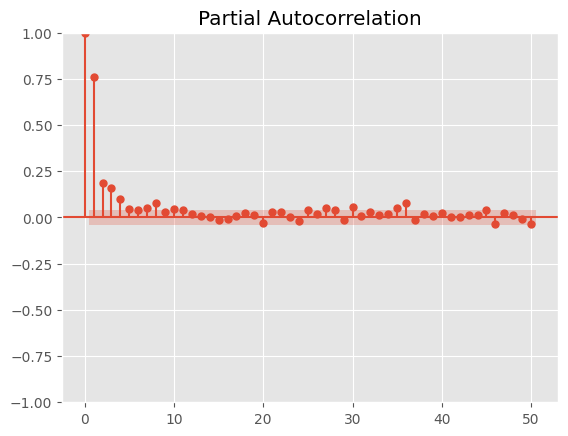

In [9]:
p_train = m.predict(df_train.append(df_valid))

df_residuals = pd.DataFrame({"ds": p_train["ds"], "residuals": p_train["y"] - p_train["yhat1"]})
fig = df_residuals.plot(x="ds", y="residuals", figsize=(10, 6))

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt = plot_acf(df_residuals["residuals"], lags=50)
plt = plot_pacf(df_residuals["residuals"], lags=50)

In [22]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {
    'weekly_seasonality': False,
    'n_lags': 1
}

m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_season_on'] = df_hol['ds'].apply(nfl_season_on)
df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)
df_hol = df_utils.add_quarter_condition(df_hol)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

folds = m.crossvalidation_split_df(df_train, freq = 'D', k = 5, fold_pct = 0.06, fold_overlap_pct=0)

m.add_country_holidays(country_name='US')
m.add_events(['nfl_season_on', 'nfl_sunday'], lower_window = 0, upper_window = 1)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
m.add_seasonality(name="weekly_summer", period=7, fourier_order=3, condition_name="summer")
m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
m.add_seasonality(name="weekly_winter", period=7, fourier_order=3, condition_name="winter")
m.add_seasonality(name="weekly_spring", period=7, fourier_order=3, condition_name="spring")

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))

metrics.metric_check(p_test.yhat1.values[config['n_lags']:], p_test.y.values[config['n_lags']:])


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\2257021749.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\2257021749.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.004519082605838776
         MAE_val            0.3436373174190521
        RMSE_val            0.4277694821357727
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
162,0.210093,0.305455


,MAE_val,RMSE_val
0,0.343637,0.427769


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\2257021749.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_test = m.predict(df_valid[len(df_valid)-1:].append(df_test))



Predicting: 57it [00:00, ?it/s]

MAE:  0.4955730100838313 ,  MSE:  0.32657576106559677 ,  RMSE:  0.5714680752811978 ,  MAPE:  0.06345337878231808 ,  MSPE:  0.005246682575654943


In [24]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {
    'weekly_seasonality': False,
    'n_lags': 3
}

m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_season_on'] = df_hol['ds'].apply(nfl_season_on)
df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)
df_hol = df_utils.add_quarter_condition(df_hol)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

folds = m.crossvalidation_split_df(df_train, freq = 'D', k = 5, fold_pct = 0.06, fold_overlap_pct=0)

m.add_country_holidays(country_name='US')
m.add_events(['nfl_season_on', 'nfl_sunday'], lower_window = 0, upper_window = 1)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
m.add_seasonality(name="weekly_summer", period=7, fourier_order=3, condition_name="summer")
m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
m.add_seasonality(name="weekly_winter", period=7, fourier_order=3, condition_name="winter")
m.add_seasonality(name="weekly_spring", period=7, fourier_order=3, condition_name="spring")

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))

metrics.metric_check(p_test.yhat1.values[config['n_lags']:], p_test.y.values[config['n_lags']:])


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\2848701675.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\2848701675.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.0038237276021391153
         MAE_val             0.303622841835022
        RMSE_val            0.3934849500656128
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
162,0.220257,0.31842


,MAE_val,RMSE_val
0,0.303623,0.393485


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\2848701675.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_test = m.predict(df_valid[len(df_valid)-3:].append(df_test))



Predicting: 57it [00:00, ?it/s]

MAE:  0.42902768218382087 ,  MSE:  0.2591617044713498 ,  RMSE:  0.5090792713039393 ,  MAPE:  0.05468086849158565 ,  MSPE:  0.00406268044790392


In [5]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {
    'weekly_seasonality': False,
    'n_lags': 4
}

m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_season_on'] = df_hol['ds'].apply(nfl_season_on)
df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)
df_hol = df_utils.add_quarter_condition(df_hol)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

folds = m.crossvalidation_split_df(df_train, freq = 'D', k = 5, fold_pct = 0.06, fold_overlap_pct=0)

m.add_country_holidays(country_name='US')
m.add_events(['nfl_season_on', 'nfl_sunday'], lower_window = 0, upper_window = 1)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
m.add_seasonality(name="weekly_summer", period=7, fourier_order=3, condition_name="summer")
m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
m.add_seasonality(name="weekly_winter", period=7, fourier_order=3, condition_name="winter")
m.add_seasonality(name="weekly_spring", period=7, fourier_order=3, condition_name="spring")

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))

metrics.metric_check(p_test.yhat1.values[config['n_lags']:], p_test.y.values[config['n_lags']:])


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18660\2583850830.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18660\2583850830.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.0036294192541390657
         MAE_val            0.29051515460014343
        RMSE_val            0.38335683941841125
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
162,0.209358,0.304269


,MAE_val,RMSE_val
0,0.290515,0.383357


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18660\2583850830.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))



Predicting: 57it [00:00, ?it/s]

MAE:  0.39067022758139436 ,  MSE:  0.22490956494826722 ,  RMSE:  0.47424631252996285 ,  MAPE:  0.049673504541914014 ,  MSPE:  0.0034651336772907053


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18660\2513080005.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_df = m.predict(df_train.append(df_valid).append(df_test))

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18660\2513080005.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_df = m.predict(df_train.append(df_valid).append(df_test))



Predicting: 57it [00:00, ?it/s]

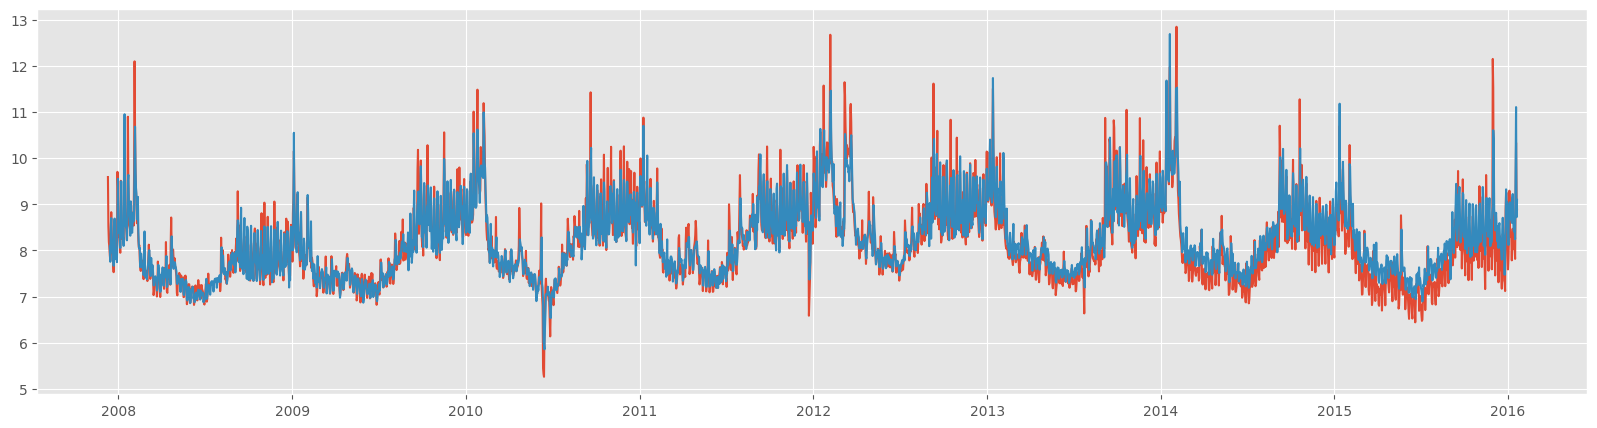

In [6]:
p_df = m.predict(df_train.append(df_valid).append(df_test))

plt.figure(figsize=(20, 5))
plt.plot(p_df.ds, p_df.y)
plt.plot(p_df.ds, p_df.yhat1)


In [28]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {
    'weekly_seasonality': False,
    'n_lags': 7
}

m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_season_on'] = df_hol['ds'].apply(nfl_season_on)
df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)
df_hol = df_utils.add_quarter_condition(df_hol)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

folds = m.crossvalidation_split_df(df_train, freq = 'D', k = 5, fold_pct = 0.06, fold_overlap_pct=0)

m.add_country_holidays(country_name='US')
m.add_events(['nfl_season_on', 'nfl_sunday'], lower_window = 0, upper_window = 1)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
m.add_seasonality(name="weekly_summer", period=7, fourier_order=3, condition_name="summer")
m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
m.add_seasonality(name="weekly_winter", period=7, fourier_order=3, condition_name="winter")
m.add_seasonality(name="weekly_spring", period=7, fourier_order=3, condition_name="spring")

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))

metrics.metric_check(p_test.yhat1.values[config['n_lags']:], p_test.y.values[config['n_lags']:])


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\767288453.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\767288453.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.003573966445401311
         MAE_val             0.286196768283844
        RMSE_val            0.38041701912879944
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
162,0.212369,0.309802


,MAE_val,RMSE_val
0,0.286197,0.380417


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\767288453.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))



Predicting: 56it [00:00, ?it/s]

MAE:  0.38709527731169296 ,  MSE:  0.2218480264224992 ,  RMSE:  0.471007458988177 ,  MAPE:  0.04917843242589727 ,  MSPE:  0.0034047492089648106


In [29]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {
    'weekly_seasonality': False,
    'n_lags': 14
}

m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_season_on'] = df_hol['ds'].apply(nfl_season_on)
df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)
df_hol = df_utils.add_quarter_condition(df_hol)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

folds = m.crossvalidation_split_df(df_train, freq = 'D', k = 5, fold_pct = 0.06, fold_overlap_pct=0)

m.add_country_holidays(country_name='US')
m.add_events(['nfl_season_on', 'nfl_sunday'], lower_window = 0, upper_window = 1)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
m.add_seasonality(name="weekly_summer", period=7, fourier_order=3, condition_name="summer")
m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
m.add_seasonality(name="weekly_winter", period=7, fourier_order=3, condition_name="winter")
m.add_seasonality(name="weekly_spring", period=7, fourier_order=3, condition_name="spring")

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))

metrics.metric_check(p_test.yhat1.values[config['n_lags']:], p_test.y.values[config['n_lags']:])


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\3816265613.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\3816265613.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.003530323738232255
         MAE_val            0.2798478305339813
        RMSE_val            0.3780871629714966
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
162,0.211688,0.307676


,MAE_val,RMSE_val
0,0.279848,0.378087


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\3816265613.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))



Predicting: 56it [00:00, ?it/s]

MAE:  0.36443542814990537 ,  MSE:  0.20433156137113842 ,  RMSE:  0.4520304872142347 ,  MAPE:  0.04617960090550037 ,  MSPE:  0.003088266039411278


In [30]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {
    'weekly_seasonality': False,
    'n_lags': 28
}

m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_season_on'] = df_hol['ds'].apply(nfl_season_on)
df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)
df_hol = df_utils.add_quarter_condition(df_hol)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

folds = m.crossvalidation_split_df(df_train, freq = 'D', k = 5, fold_pct = 0.06, fold_overlap_pct=0)

m.add_country_holidays(country_name='US')
m.add_events(['nfl_season_on', 'nfl_sunday'], lower_window = 0, upper_window = 1)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
m.add_seasonality(name="weekly_summer", period=7, fourier_order=3, condition_name="summer")
m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
m.add_seasonality(name="weekly_winter", period=7, fourier_order=3, condition_name="winter")
m.add_seasonality(name="weekly_spring", period=7, fourier_order=3, condition_name="spring")

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))

metrics.metric_check(p_test.yhat1.values[config['n_lags']:], p_test.y.values[config['n_lags']:])


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\1636059883.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\1636059883.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.0037940361071377993
         MAE_val            0.2980128824710846
        RMSE_val             0.391954243183136
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
162,0.210501,0.303827


,MAE_val,RMSE_val
0,0.298013,0.391954


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\1636059883.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))



Predicting: 56it [00:00, ?it/s]

MAE:  0.39610687611051454 ,  MSE:  0.2278314907945267 ,  RMSE:  0.47731697098943243 ,  MAPE:  0.05036742790950129 ,  MSPE:  0.003520107879744078


In [31]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {
    'weekly_seasonality': False,
    'n_lags': 30
}

m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_season_on'] = df_hol['ds'].apply(nfl_season_on)
df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)
df_hol = df_utils.add_quarter_condition(df_hol)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

folds = m.crossvalidation_split_df(df_train, freq = 'D', k = 5, fold_pct = 0.06, fold_overlap_pct=0)

m.add_country_holidays(country_name='US')
m.add_events(['nfl_season_on', 'nfl_sunday'], lower_window = 0, upper_window = 1)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
m.add_seasonality(name="weekly_summer", period=7, fourier_order=3, condition_name="summer")
m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
m.add_seasonality(name="weekly_winter", period=7, fourier_order=3, condition_name="winter")
m.add_seasonality(name="weekly_spring", period=7, fourier_order=3, condition_name="spring")

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))

metrics.metric_check(p_test.yhat1.values[config['n_lags']:], p_test.y.values[config['n_lags']:])


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\1962293978.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\1962293978.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.0036162559408694506
         MAE_val            0.28681865334510803
        RMSE_val            0.38266104459762573
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
162,0.212572,0.307652


,MAE_val,RMSE_val
0,0.286819,0.382661


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\1962293978.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))



Predicting: 56it [00:00, ?it/s]

MAE:  0.37095105260404687 ,  MSE:  0.2081224491872983 ,  RMSE:  0.4562043940903006 ,  MAPE:  0.047010617271719145 ,  MSPE:  0.003163334825447698


In [7]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {
    'weekly_seasonality': False,
    'n_lags': 91
}

m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_season_on'] = df_hol['ds'].apply(nfl_season_on)
df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)
df_hol = df_utils.add_quarter_condition(df_hol)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

folds = m.crossvalidation_split_df(df_train, freq = 'D', k = 5, fold_pct = 0.06, fold_overlap_pct=0)

m.add_country_holidays(country_name='US')
m.add_events(['nfl_season_on', 'nfl_sunday'], lower_window = 0, upper_window = 1)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
m.add_seasonality(name="weekly_summer", period=7, fourier_order=3, condition_name="summer")
m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
m.add_seasonality(name="weekly_winter", period=7, fourier_order=3, condition_name="winter")
m.add_seasonality(name="weekly_spring", period=7, fourier_order=3, condition_name="spring")

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))

metrics.metric_check(p_test.yhat1.values[config['n_lags']:], p_test.y.values[config['n_lags']:])


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18660\3591497634.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18660\3591497634.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.003613219829276204
         MAE_val            0.2687060534954071
        RMSE_val            0.3825003504753113
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
164,0.214583,0.304524


,MAE_val,RMSE_val
0,0.268706,0.3825


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18660\3591497634.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))



Predicting: 54it [00:00, ?it/s]

MAE:  0.31310318967071604 ,  MSE:  0.17070020426829505 ,  RMSE:  0.413158812405466 ,  MAPE:  0.03904010030989119 ,  MSPE:  0.002403456751462727


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18660\2513080005.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_df = m.predict(df_train.append(df_valid).append(df_test))

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18660\2513080005.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_df = m.predict(df_train.append(df_valid).append(df_test))



Predicting: 54it [00:00, ?it/s]

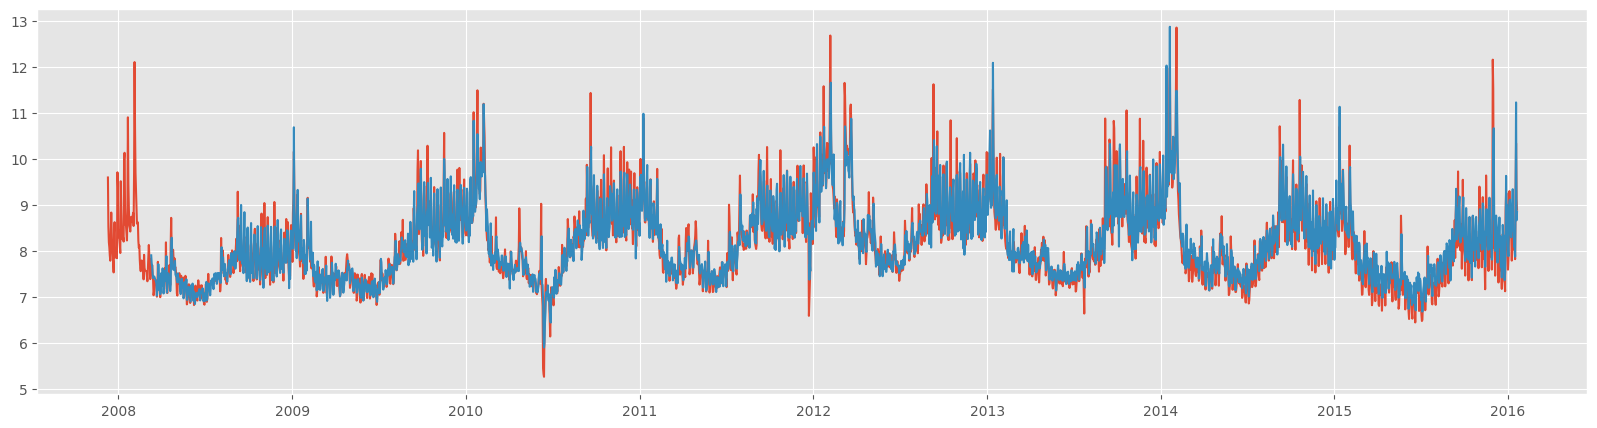

In [8]:
p_df = m.predict(df_train.append(df_valid).append(df_test))

plt.figure(figsize=(20, 5))
plt.plot(p_df.ds, p_df.y)
plt.plot(p_df.ds, p_df.yhat1)


In [33]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {
    'weekly_seasonality': False,
    'n_lags': 182
}

m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_season_on'] = df_hol['ds'].apply(nfl_season_on)
df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)
df_hol = df_utils.add_quarter_condition(df_hol)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

folds = m.crossvalidation_split_df(df_train, freq = 'D', k = 5, fold_pct = 0.06, fold_overlap_pct=0)

m.add_country_holidays(country_name='US')
m.add_events(['nfl_season_on', 'nfl_sunday'], lower_window = 0, upper_window = 1)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
m.add_seasonality(name="weekly_summer", period=7, fourier_order=3, condition_name="summer")
m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
m.add_seasonality(name="weekly_winter", period=7, fourier_order=3, condition_name="winter")
m.add_seasonality(name="weekly_spring", period=7, fourier_order=3, condition_name="spring")

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))

metrics.metric_check(p_test.yhat1.values[config['n_lags']:], p_test.y.values[config['n_lags']:])


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\4131018773.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\4131018773.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.004374546464532614
         MAE_val            0.3018277883529663
        RMSE_val            0.42087310552597046
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
167,0.219045,0.306305


,MAE_val,RMSE_val
0,0.301828,0.420873


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22372\4131018773.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))



Predicting: 51it [00:00, ?it/s]

MAE:  0.34073403331319124 ,  MSE:  0.18946507735268708 ,  RMSE:  0.4352758635080598 ,  MAPE:  0.04274611376469408 ,  MSPE:  0.002742667596856358


## NN layer 추가

In [6]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {
    'weekly_seasonality': False,
    'n_lags': 4,
    'ar_layers': [1, 32]    
}

m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_season_on'] = df_hol['ds'].apply(nfl_season_on)
df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)
df_hol = df_utils.add_quarter_condition(df_hol)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

folds = m.crossvalidation_split_df(df_train, freq = 'D', k = 5, fold_pct = 0.06, fold_overlap_pct=0)

m.add_country_holidays(country_name='US')
m.add_events(['nfl_season_on', 'nfl_sunday'], lower_window = 0, upper_window = 1)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
m.add_seasonality(name="weekly_summer", period=7, fourier_order=3, condition_name="summer")
m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
m.add_seasonality(name="weekly_winter", period=7, fourier_order=3, condition_name="winter")
m.add_seasonality(name="weekly_spring", period=7, fourier_order=3, condition_name="spring")

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))

metrics.metric_check(p_test.yhat1.values[config['n_lags']:], p_test.y.values[config['n_lags']:])


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20124\1489497185.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20124\1489497185.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.0035323963966220617
         MAE_val             0.267977237701416
        RMSE_val            0.37819814682006836
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
162,0.213187,0.305655


,MAE_val,RMSE_val
0,0.267977,0.378198


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20124\1489497185.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))



Predicting: 57it [00:00, ?it/s]

MAE:  0.3179791907067078 ,  MSE:  0.20014061750903928 ,  RMSE:  0.44737078303018324 ,  MAPE:  0.03960802539460446 ,  MSPE:  0.0028712744391082823


In [4]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {
    'weekly_seasonality': False,
    'n_lags': 4,
    'ar_layers': [2, 24]    
}

m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_season_on'] = df_hol['ds'].apply(nfl_season_on)
df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)
df_hol = df_utils.add_quarter_condition(df_hol)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

folds = m.crossvalidation_split_df(df_train, freq = 'D', k = 5, fold_pct = 0.06, fold_overlap_pct=0)

m.add_country_holidays(country_name='US')
m.add_events(['nfl_season_on', 'nfl_sunday'], lower_window = 0, upper_window = 1)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
m.add_seasonality(name="weekly_summer", period=7, fourier_order=3, condition_name="summer")
m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
m.add_seasonality(name="weekly_winter", period=7, fourier_order=3, condition_name="winter")
m.add_seasonality(name="weekly_spring", period=7, fourier_order=3, condition_name="spring")

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))

metrics.metric_check(p_test.yhat1.values[config['n_lags']:], p_test.y.values[config['n_lags']:])

Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2132\18388944.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2132\18388944.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.0031817995477467775
         MAE_val            0.2459261417388916
        RMSE_val            0.35893934965133667
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
162,0.220124,0.31364


,MAE_val,RMSE_val
0,0.245926,0.358939


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2132\18388944.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))



Predicting: 57it [00:00, ?it/s]

MAE:  0.3201269323317914 ,  MSE:  0.18460654012008196 ,  RMSE:  0.4296586320790983 ,  MAPE:  0.04016066260012753 ,  MSPE:  0.0027083635867955823


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2132\2513080005.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_df = m.predict(df_train.append(df_valid).append(df_test))

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2132\2513080005.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_df = m.predict(df_train.append(df_valid).append(df_test))



Predicting: 57it [00:00, ?it/s]

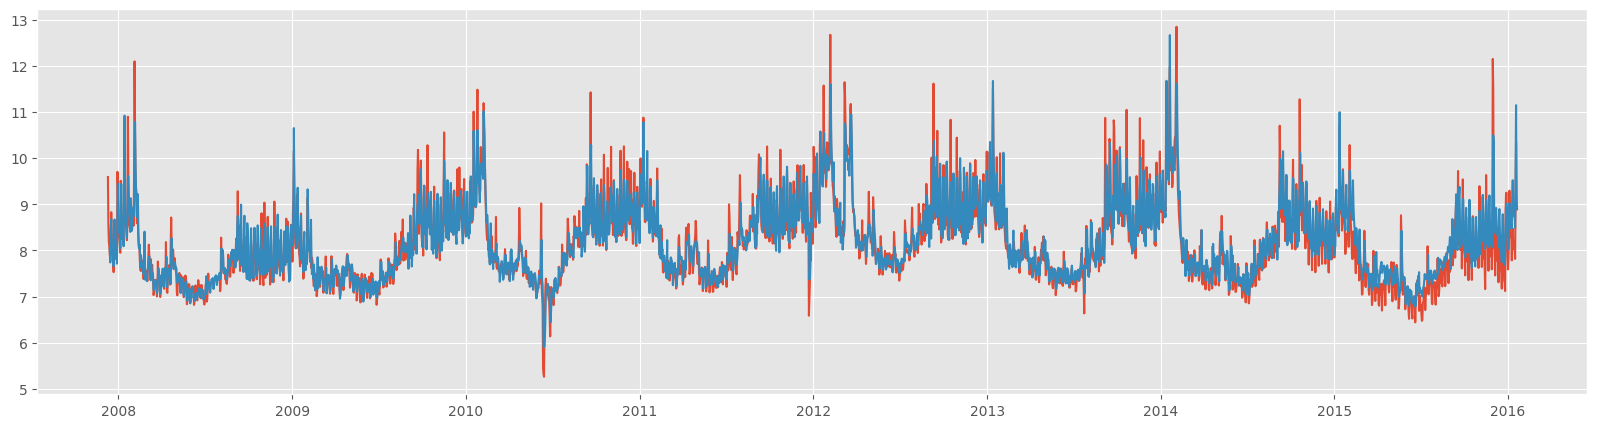

In [5]:
p_df = m.predict(df_train.append(df_valid).append(df_test))

plt.figure(figsize=(20, 5))
plt.plot(p_df.ds, p_df.y)
plt.plot(p_df.ds, p_df.yhat1)


In [8]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {
    'weekly_seasonality': False,
    'n_lags': 4,
    'ar_layers': [4, 16]    
}

m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_season_on'] = df_hol['ds'].apply(nfl_season_on)
df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)
df_hol = df_utils.add_quarter_condition(df_hol)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

folds = m.crossvalidation_split_df(df_train, freq = 'D', k = 5, fold_pct = 0.06, fold_overlap_pct=0)

m.add_country_holidays(country_name='US')
m.add_events(['nfl_season_on', 'nfl_sunday'], lower_window = 0, upper_window = 1)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
m.add_seasonality(name="weekly_summer", period=7, fourier_order=3, condition_name="summer")
m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
m.add_seasonality(name="weekly_winter", period=7, fourier_order=3, condition_name="winter")
m.add_seasonality(name="weekly_spring", period=7, fourier_order=3, condition_name="spring")

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))

metrics.metric_check(p_test.yhat1.values[config['n_lags']:], p_test.y.values[config['n_lags']:])

Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20124\1868237974.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20124\1868237974.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.004806113429367542
         MAE_val            0.36133840680122375
        RMSE_val            0.44114530086517334
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
162,0.207093,0.29884


,MAE_val,RMSE_val
0,0.361338,0.441145


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20124\1868237974.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))



Predicting: 57it [00:00, ?it/s]

MAE:  0.47023283098874535 ,  MSE:  0.3091743526316842 ,  RMSE:  0.5560344887070263 ,  MAPE:  0.05990765833414732 ,  MSPE:  0.0048912239915673535


In [10]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {
    'weekly_seasonality': False,
    'n_lags': 4,
    'ar_layers': [32, 32, 32, 32]    
}

m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_season_on'] = df_hol['ds'].apply(nfl_season_on)
df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)
df_hol = df_utils.add_quarter_condition(df_hol)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

folds = m.crossvalidation_split_df(df_train, freq = 'D', k = 5, fold_pct = 0.06, fold_overlap_pct=0)

m.add_country_holidays(country_name='US')
m.add_events(['nfl_season_on', 'nfl_sunday'], lower_window = 0, upper_window = 1)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
m.add_seasonality(name="weekly_summer", period=7, fourier_order=3, condition_name="summer")
m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
m.add_seasonality(name="weekly_winter", period=7, fourier_order=3, condition_name="winter")
m.add_seasonality(name="weekly_spring", period=7, fourier_order=3, condition_name="spring")

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))

metrics.metric_check(p_test.yhat1.values[config['n_lags']:], p_test.y.values[config['n_lags']:])

Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20124\1833938177.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20124\1833938177.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.018889714032411575
         MAE_val            0.7699228525161743
        RMSE_val            0.8745755553245544
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
162,0.29373,0.412285


,MAE_val,RMSE_val
0,0.769923,0.874576


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20124\1833938177.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))



Predicting: 57it [00:00, ?it/s]

MAE:  1.3477134750833721 ,  MSE:  2.043666716853396 ,  RMSE:  1.4295687170798739 ,  MAPE:  0.17396975728717576 ,  MSPE:  0.03471891661411072


In [11]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {
    'weekly_seasonality': False,
    'n_lags': 4,
    'ar_layers': [24, 24, 24, 24]    
}

m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_season_on'] = df_hol['ds'].apply(nfl_season_on)
df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)
df_hol = df_utils.add_quarter_condition(df_hol)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

folds = m.crossvalidation_split_df(df_train, freq = 'D', k = 5, fold_pct = 0.06, fold_overlap_pct=0)

m.add_country_holidays(country_name='US')
m.add_events(['nfl_season_on', 'nfl_sunday'], lower_window = 0, upper_window = 1)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
m.add_seasonality(name="weekly_summer", period=7, fourier_order=3, condition_name="summer")
m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
m.add_seasonality(name="weekly_winter", period=7, fourier_order=3, condition_name="winter")
m.add_seasonality(name="weekly_spring", period=7, fourier_order=3, condition_name="spring")

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))

metrics.metric_check(p_test.yhat1.values[config['n_lags']:], p_test.y.values[config['n_lags']:])

Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20124\3064274148.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20124\3064274148.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.01357846800237894
         MAE_val            0.5414634943008423
        RMSE_val            0.7418114542961121
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
162,0.286586,0.418484


,MAE_val,RMSE_val
0,0.541463,0.741811


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20124\3064274148.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))



Predicting: 57it [00:00, ?it/s]

MAE:  0.9074950826153702 ,  MSE:  1.2671020420271966 ,  RMSE:  1.1256562717042875 ,  MAPE:  0.11695960404181226 ,  MSPE:  0.021525939151708997


In [12]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_valid = pd.DataFrame(columns=METRICS_VAL)

set_random_seed(1234)

config = {
    'weekly_seasonality': False,
    'n_lags': 4,
    'ar_layers': [16, 16, 16, 16]    
}

m = NeuralProphet(**config)

m.add_events(['playoff', 'superbowl'], lower_window = 0, upper_window = 1)
df_hol = m.create_df_with_events(df1, holidays)

df_hol['nfl_season_on'] = df_hol['ds'].apply(nfl_season_on)
df_hol['nfl_sunday'] = df_hol['ds'].apply(nfl_sunday)
df_hol = df_utils.add_quarter_condition(df_hol)

df_train = df_hol[df_hol.ds < '2012-11-10']
df_valid = df_hol[('2012-11-10' <= df_hol.ds) & (df_hol.ds < '2014-06-16')].reset_index(drop = True)
df_test = df_hol['2014-06-16' <= df_hol.ds].reset_index(drop = True)

folds = m.crossvalidation_split_df(df_train, freq = 'D', k = 5, fold_pct = 0.06, fold_overlap_pct=0)

m.add_country_holidays(country_name='US')
m.add_events(['nfl_season_on', 'nfl_sunday'], lower_window = 0, upper_window = 1)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
m.add_seasonality(name="weekly_summer", period=7, fourier_order=3, condition_name="summer")
m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
m.add_seasonality(name="weekly_winter", period=7, fourier_order=3, condition_name="winter")
m.add_seasonality(name="weekly_spring", period=7, fourier_order=3, condition_name="spring")

train = m.fit(df=df_train, freq="D")
valid = m.test(df=df_valid)
metrics_train = metrics_train.append(train[METRICS].iloc[-1])
metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])

display(metrics_train)
display(metrics_valid)

p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))

metrics.metric_check(p_test.yhat1.values[config['n_lags']:], p_test.y.values[config['n_lags']:])

Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20124\3920748238.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train = metrics_train.append(train[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20124\3920748238.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_valid = metrics_valid.append(valid[METRICS_VAL].iloc[-1])



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.004341214429587126
         MAE_val             0.333018034696579
        RMSE_val            0.41926661133766174
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,RMSE
162,0.21346,0.305249


,MAE_val,RMSE_val
0,0.333018,0.419267


WARNING - (py.warnings._showwarnmsg) - C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20124\3920748238.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_test = m.predict(df_valid[len(df_valid)-config['n_lags']:].append(df_test))



Predicting: 57it [00:00, ?it/s]

MAE:  0.605876869678994 ,  MSE:  0.4624435312823281 ,  RMSE:  0.6800320075425333 ,  MAPE:  0.07774123620757652 ,  MSPE:  0.007576301688109733
